In [49]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [50]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [51]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "test_images",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

print('Class names:', df.class_names)

Found 2152 files belonging to 3 classes.
Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [52]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [53]:
len(df)

68

In [54]:
for image_batch, labels_batch in df.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 1 0 0 1 0 1 0 0 1 2 2 1 2 2 0 1 1 0 1 2 1 1 0 2 0 0 1 1]


As we can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

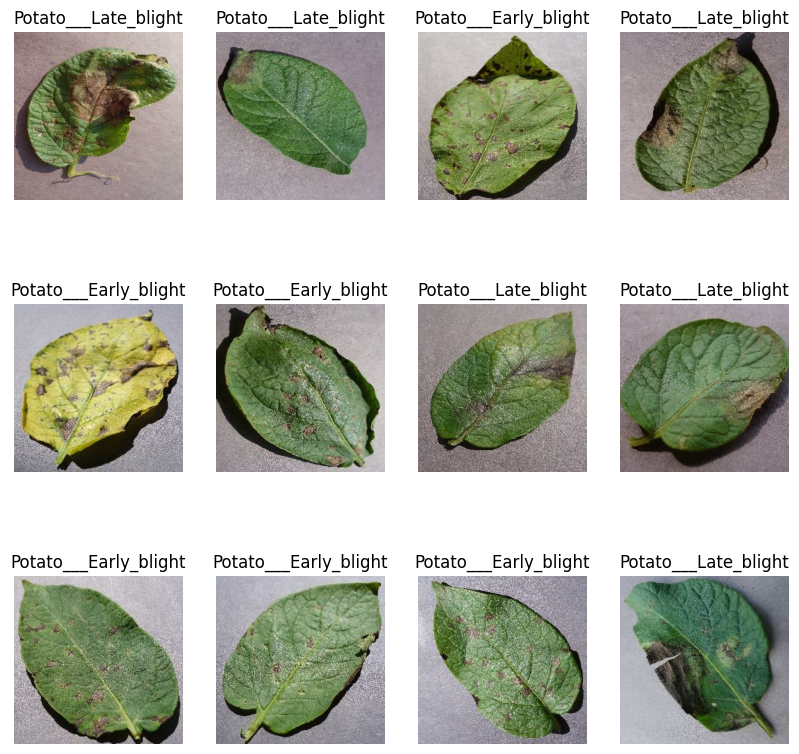

In [55]:
plt.figure(figsize=(10, 10))    
for image_batch, label_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Dataset is to be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model


In [56]:
len(df)

68

In [57]:
train_size = 0.8
len(df) * train_size

54.400000000000006

In [58]:
train_df = df.take(54)
len(train_df)

54

In [59]:
test_df = df.skip(54)
len(test_df)

14

In [60]:
val_size=0.1
len(df)*val_size

6.800000000000001

In [61]:
val_df = test_df.take(6)
len(val_df)

6

In [62]:
test_df = test_df.skip(6)
len(test_df)

8

In [63]:
def get_dataset_partitions_tf(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    df_size = len(df)
    
    if shuffle:
        df = df.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * df_size)
    val_size = int(val_split * df_size)

    train_df = df.take(train_size)    
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)
    
    return train_df, val_df, test_df

In [64]:
train_df, val_df, test_df = get_dataset_partitions_tf(df)

In [65]:
len(train_df)

54

In [66]:
len(val_df)

6

In [67]:
len(test_df)

8

Caching, Shuffling and Prefetching the dataset

In [68]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [69]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])

In [70]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [71]:
train_df = train_df.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [72]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/Users/vedantwalia/Desktop/Projects sandbox/potato-disease-classification/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [73]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [75]:
history = model.fit(
    train_df,
    batch_size=BATCH_SIZE,
    validation_data=val_df,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 599ms/step - accuracy: 0.4940 - loss: 0.9120 - val_accuracy: 0.5260 - val_loss: 0.7744
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 742ms/step - accuracy: 0.6775 - loss: 0.6707 - val_accuracy: 0.7917 - val_loss: 0.4955
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 707ms/step - accuracy: 0.7740 - loss: 0.5321 - val_accuracy: 0.8438 - val_loss: 0.3857
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 652ms/step - accuracy: 0.8246 - loss: 0.4064 - val_accuracy: 0.9115 - val_loss: 0.2189
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 624ms/step - accuracy: 0.8922 - loss: 0.2708 - val_accuracy: 0.9219 - val_loss: 0.2401
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 641ms/step - accuracy: 0.9061 - loss: 0.2652 - val_accuracy: 0.9323 - val_loss: 0.2260
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 802ms/step - accuracy: 0.9191 - loss: 0.1890 - val_accuracy: 0.9167 - val_loss: 0.2061
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 904ms/step - accuracy: 0.9200 - loss: 0.1851 - val_accu

In [76]:
score = model.evaluate(test_df)
score

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.9816 - loss: 0.0526


[0.04662025719881058, 0.984375]

In [77]:
history

In [78]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [79]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

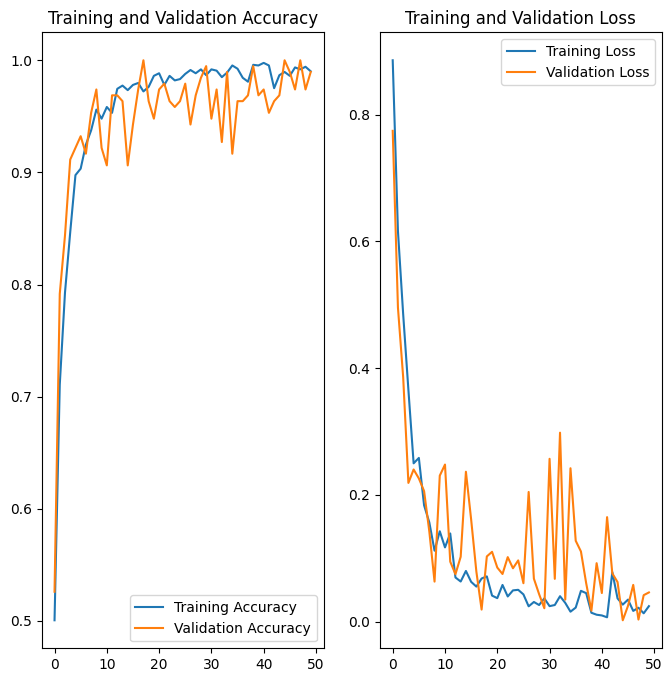

In [81]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
predicted label: Potato___Early_blight


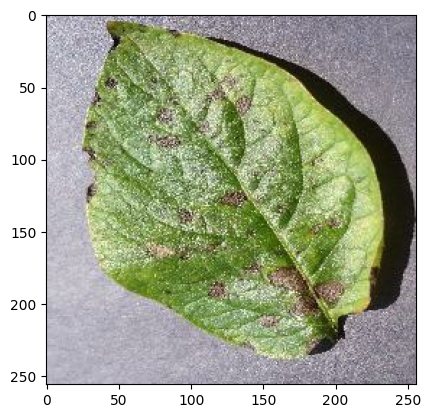

In [82]:
import numpy as np
for images_batch, labels_batch in test_df.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [83]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2026-01-05 15:59:17.569021: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


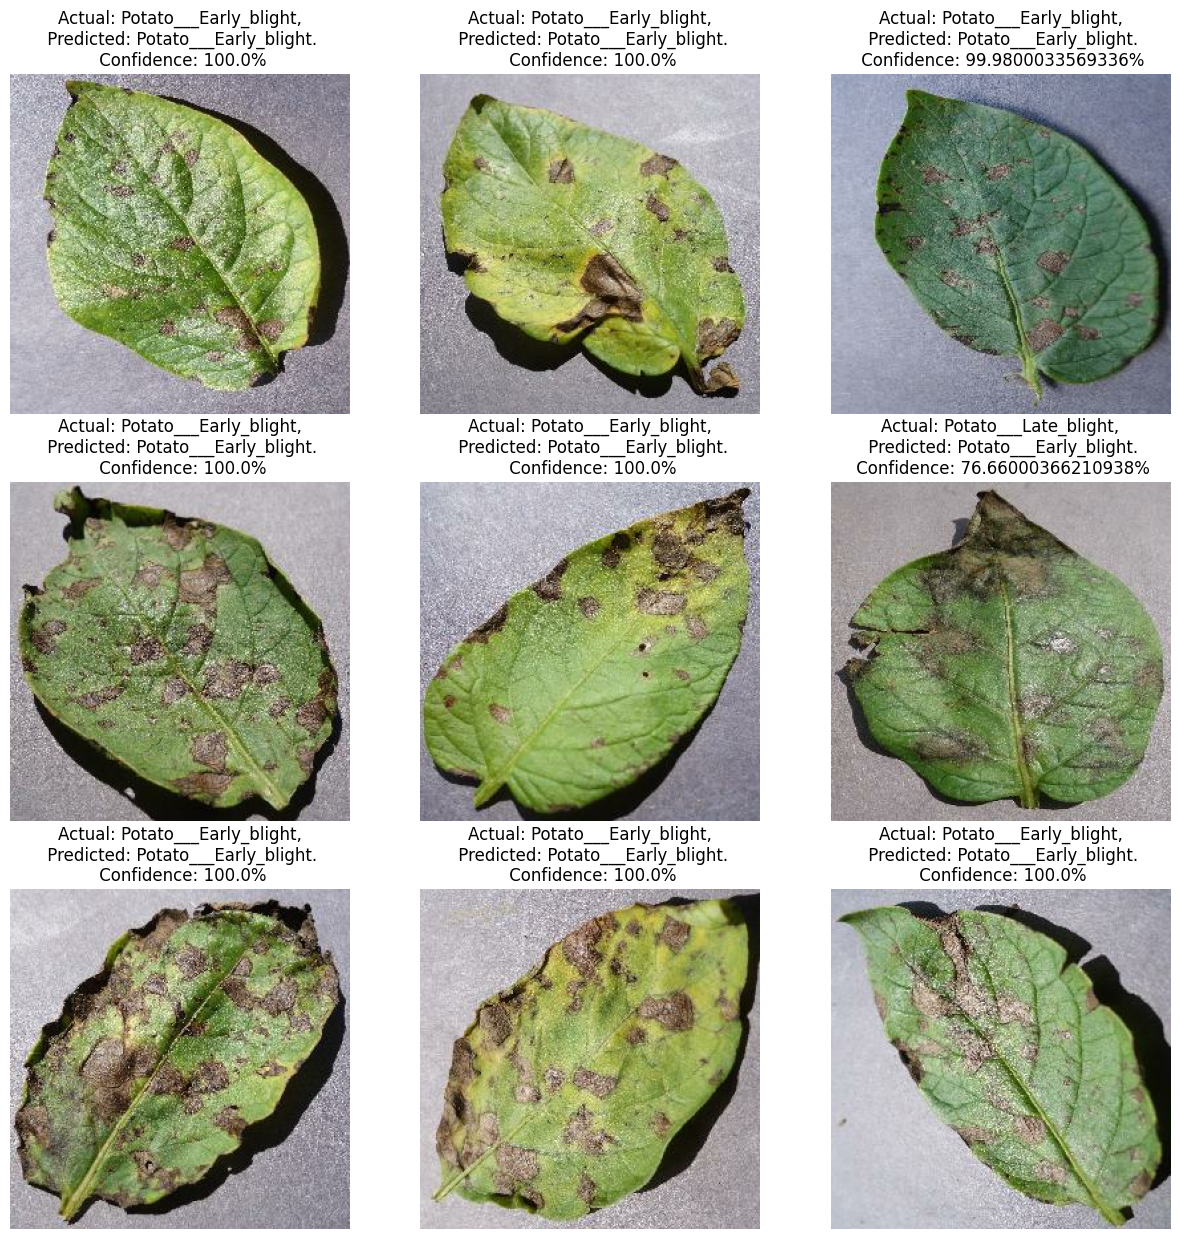

In [84]:
plt.figure(figsize=(15, 15))
for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [85]:
import os
os.makedirs("models", exist_ok=True)
model_dirs = [d for d in os.listdir("models") if d.isdigit()]
model_version = max([int(d) for d in model_dirs] + [0]) + 1
model.save(f"models/{model_version}.keras")

In [86]:
model.save("../potatoes.keras")